# Partie 1

In [98]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt


def extract_data(input_path, pattern):
    with open(input_path, 'r') as file:
        content = file.read()
    matches = re.findall(pattern, content, re.MULTILINE)
    data = []
    for match in matches:
        numbers = match[1].replace('\n', ' ').split()
        numbers_float = [float(number) for number in numbers]
        data.append(numbers_float)
    return pd.DataFrame(data)

rocks_path = 'data/sonar.rocks'
mines_path = 'data/sonar.mines'


train_pattern = r'\*(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'
test_pattern = r'^(?!\*)(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'


rocks_train_df = extract_data(rocks_path, train_pattern)
mines_train_df = extract_data(mines_path, train_pattern)
rocks_train_df['Label'] = 'R'  
mines_train_df['Label'] = 'M' 
train_df = pd.concat([rocks_train_df, mines_train_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

rocks_test_df = extract_data(rocks_path, test_pattern)
mines_test_df = extract_data(mines_path, test_pattern)
rocks_test_df['Label'] = 'R'  
mines_test_df['Label'] = 'M' 
test_df = pd.concat([rocks_test_df, mines_test_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

## Algorithme d'entraînement

In [99]:
def predict_perceptron(inputs, weights):
    activation = np.dot(inputs, weights[1:]) + weights[0]
    return 1 if activation >= 0 else -1


def calculate_accuracy(features, labels, weights):
    predictions = [predict_perceptron(x, weights) for x in features]
    correct_predictions = sum(pred == label for pred, label in zip(predictions, labels))
    accuracy = correct_predictions / len(labels)
    return accuracy

def calculate_error(weights, training_features, training_labels):
    errors = 0
    for inputs, label in zip(training_features, training_labels):
        inputs_with_bias = np.insert(inputs, 0, 1)
        prediction = np.sign(np.dot(weights, inputs_with_bias))
        if prediction != label:
            errors += 1
    return errors


In [100]:
def minimerror_perceptron(weightsT,training_features, training_labels, epochs, learning_rate, T_initial, T_decrease_factor, patience=200):
    T = T_initial
    weights = weightsT
    previous_errors = float('inf')
    no_improvement_count = 0
    current_errors = np.zeros(epochs)
    for epoch in range(epochs):
        for inputs, label in zip(training_features, training_labels):
            inputs_with_bias = np.insert(inputs, 0, 1)
            stability = (np.dot(inputs_with_bias, weights) * label) / np.linalg.norm(weights[1:])
            derivative = -inputs_with_bias * label / (4 * T * np.cosh(stability / (2 * T))**2)
            weights[1:] -= learning_rate * derivative[1:] / np.linalg.norm(weights[1:])
            weights[0] -= learning_rate * derivative[0]

        current_errors[epoch] = calculate_error(weights, training_features, training_labels)
        
        if current_errors[epoch] < previous_errors:
            previous_errors = current_errors[epoch]
            no_improvement_count = 0
            weightsT = weights
        else:
            no_improvement_count += 1 

        if no_improvement_count >= patience:
            print(f'Arrêt prématuré après {epoch+1} époques en raison de l\'absence d\'amélioration.')
            break

        T *= T_decrease_factor

        print(f'Epoch {epoch+1}/{epochs}, Erreurs: {current_errors[epoch]}, Température: {T}')

    return weightsT, current_errors[:epoch+1]


In [101]:
weightsT = np.random.uniform(low=0.3, high=0.4, size=train_features.shape[1] + 1)
print(weightsT) 
train_df['Label'] = train_df['Label'].apply(lambda x: 1 if x == 'M' else -1)
test_df['Label'] = test_df['Label'].apply(lambda x: 1 if x == 'M' else -1)


test_features = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values


train_features = train_df.iloc[:, :-1].values
train_labels = train_df.iloc[:, -1].values

weights3,errors = minimerror_perceptron(weightsT,train_features, train_labels, epochs=10000, learning_rate=0.02, T_initial=80, T_decrease_factor=0.99, patience=500)
print(weights3)
training_accuracy3 = calculate_accuracy(train_features, train_labels, weights3)
testing_accuracy3 = calculate_accuracy(test_features, test_labels, weights3)


Ea3 = 1 - training_accuracy3
Eg3 = 1 - testing_accuracy3

print(f"Erreur d'apprentissage (Ea) : {Ea3}")
print(f"Erreur de généralisation (Eg) : {Eg3}")

[0.3529639  0.34578846 0.3550034  0.31657454 0.32085302 0.37687388
 0.37532751 0.32051601 0.37346516 0.32436905 0.35958375 0.38447579
 0.34218759 0.38531216 0.3110311  0.39379062 0.34948964 0.31130423
 0.35367799 0.38536051 0.31163027 0.3565001  0.39961527 0.39288212
 0.36215878 0.3927613  0.30927771 0.33616289 0.338179   0.33613593
 0.33131538 0.30652388 0.38188874 0.34480309 0.33615315 0.31393395
 0.36733647 0.30039406 0.30361159 0.39038055 0.39043704 0.34162685
 0.35628645 0.35385702 0.38337514 0.34752746 0.37615891 0.32217374
 0.38567763 0.31208419 0.30159801 0.35296523 0.36709601 0.35284708
 0.39337212 0.35754439 0.3369914  0.34540624 0.31773535 0.37033411
 0.33130897]
Epoch 1/10000, Erreurs: 55.0, Température: 79.2
Epoch 2/10000, Erreurs: 55.0, Température: 78.408
Epoch 3/10000, Erreurs: 55.0, Température: 77.62392
Epoch 4/10000, Erreurs: 55.0, Température: 76.84768079999999
Epoch 5/10000, Erreurs: 55.0, Température: 76.07920399199999
Epoch 6/10000, Erreurs: 55.0, Température: 75

C:\Users\Administrator\AppData\Local\Temp\ipykernel_56552\1722818886.py:11: RuntimeWarning: overflow encountered in scalar power
  derivative = -inputs_with_bias * label / (4 * T * np.cosh(stability / (2 * T))**2)


Epoch 1152/10000, Erreurs: 15.0, Température: 0.0007496079146785949
Epoch 1153/10000, Erreurs: 15.0, Température: 0.0007421118355318089
Epoch 1154/10000, Erreurs: 15.0, Température: 0.0007346907171764908
Epoch 1155/10000, Erreurs: 15.0, Température: 0.0007273438100047259
Epoch 1156/10000, Erreurs: 15.0, Température: 0.0007200703719046787
Epoch 1157/10000, Erreurs: 15.0, Température: 0.0007128696681856319
Epoch 1158/10000, Erreurs: 15.0, Température: 0.0007057409715037756
Epoch 1159/10000, Erreurs: 15.0, Température: 0.0006986835617887378
Epoch 1160/10000, Erreurs: 15.0, Température: 0.0006916967261708504
Epoch 1161/10000, Erreurs: 15.0, Température: 0.000684779758909142
Epoch 1162/10000, Erreurs: 15.0, Température: 0.0006779319613200506
Epoch 1163/10000, Erreurs: 15.0, Température: 0.00067115264170685
Epoch 1164/10000, Erreurs: 15.0, Température: 0.0006644411152897815
Epoch 1165/10000, Erreurs: 15.0, Température: 0.0006577967041368837
Epoch 1166/10000, Erreurs: 15.0, Température: 0.000

C:\Users\Administrator\AppData\Local\Temp\ipykernel_56552\1722818886.py:11: RuntimeWarning: overflow encountered in cosh
  derivative = -inputs_with_bias * label / (4 * T * np.cosh(stability / (2 * T))**2)


Epoch 1191/10000, Erreurs: 15.0, Température: 0.0005065318433538287
Epoch 1192/10000, Erreurs: 15.0, Température: 0.0005014665249202904
Epoch 1193/10000, Erreurs: 15.0, Température: 0.0004964518596710875
Epoch 1194/10000, Erreurs: 15.0, Température: 0.0004914873410743766
Epoch 1195/10000, Erreurs: 15.0, Température: 0.00048657246766363287
Epoch 1196/10000, Erreurs: 15.0, Température: 0.0004817067429869965
Epoch 1197/10000, Erreurs: 15.0, Température: 0.00047688967555712655
Epoch 1198/10000, Erreurs: 15.0, Température: 0.0004721207788015553
Epoch 1199/10000, Erreurs: 15.0, Température: 0.00046739957101353974
Epoch 1200/10000, Erreurs: 15.0, Température: 0.00046272557530340435
Epoch 1201/10000, Erreurs: 15.0, Température: 0.0004580983195503703
Epoch 1202/10000, Erreurs: 15.0, Température: 0.0004535173363548666
Epoch 1203/10000, Erreurs: 15.0, Température: 0.00044898216299131793
Epoch 1204/10000, Erreurs: 15.0, Température: 0.00044449234136140475
Epoch 1205/10000, Erreurs: 15.0, Températu

Stabilité : 0.15866438426755697
Accuracy sur le jeu d'entraînement : 0.8557692307692307
Accuracy sur le jeu de test : 0.7403846153846154
Erreur d'apprentissage (Ea) : 0.14423076923076927
Erreur de généralisation (Eg) : 0.2596153846153846
Stabilité : 0.15866438426755697
Poids : [-8.11028674  0.65996844  1.373811    1.29423612  1.95525303  1.99480017
  1.28072892  0.71323239  0.51476625  2.67738604  2.88481878  3.16085395
  2.45573794  1.44507153  0.38612007 -0.66610337 -1.49545608 -1.43976345
 -0.87249606  0.354177   -0.45478851 -0.10336576  1.6158747   0.98550255
  0.22878506  0.22732347  0.35658785  1.38131158  1.86771745  1.0441474
  1.21756677 -0.80677019  0.65075143 -0.49907362 -0.88496732 -1.71813253
 -2.50967848 -1.63167332  0.07686347 -0.34608112  0.14807192  2.50791071
  0.50264056 -0.11822011  1.33558663  2.75833042  2.13299133  1.95920782
  1.96103871  1.59813332  0.35015417  0.57110955  0.61920993  0.42502548
  0.50539294  0.36367655  0.32000086  0.30940373  0.37039866  0.38

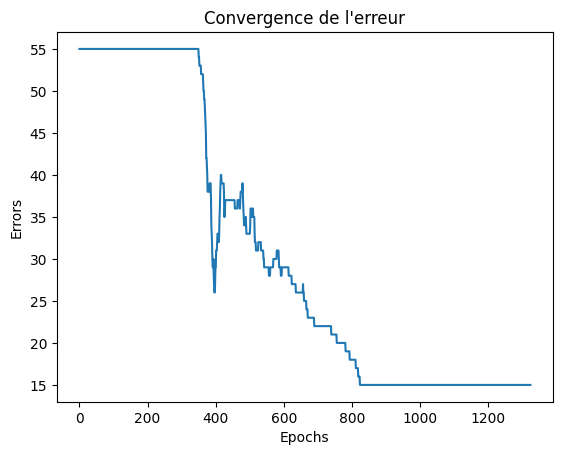

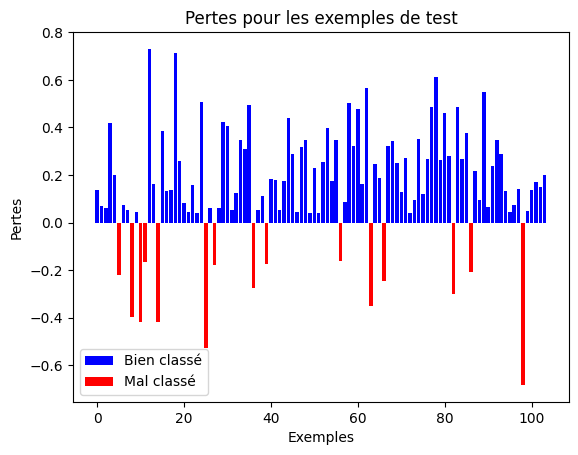

In [102]:
# affichage de stabilité
stability = []
for inputs, label in zip(train_features, train_labels):
    inputs_with_bias = np.insert(inputs, 0, 1)
    stability.append((np.dot(inputs_with_bias, weights3) * label) / np.linalg.norm(weights3[1:]))

print(f"Accuracy sur le jeu d'entraînement : {training_accuracy3*100}%")
print(f"Accuracy sur le jeu de test : {testing_accuracy3*100}%")

print(f"Erreur d'apprentissage (Ea) : {Ea3}")
print(f"Erreur de généralisation (Eg) : {Eg3}")
print(f"Poids : {weights3}")

# Affichage de graphique de convergence de l'erreur
plt.plot(range(len(errors)), errors)
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Convergence de l\'erreur')
plt.show()



# Affichage du graphique
plt.bar(range(len(stability)), [val if val > 0 else 0 for val in stability], 
        color='blue', label='Bien classé')

# Barres pour les exemples classés comme roches
plt.bar(range(len(stability)), [val if val < 0 else 0 for val in stability], 
        color='red', label='Mal classé')

# Ajout des étiquettes
plt.xlabel('Exemples')
plt.ylabel('Pertes')
plt.title('Pertes pour les exemples de test')
plt.legend()
plt.show()

PARTIE 2 :

In [103]:


def minimerror_perceptron4(training_features, training_labels, epochs, initial_learning_rate, T_plus_initial, T_minus_initial, T_decrease_factor, patience, decay):
    weights = np.random.uniform(low=0.3, high=0.4, size=(training_features.shape[1] + 1))
    T_plus = T_plus_initial
    T_minus = T_minus_initial
    previous_errors = float('inf')
    no_improvement_count = 0
    learning_rate = initial_learning_rate
    current_errors = np.zeros(epochs)
    for epoch in range(epochs):
        for inputs, label in zip(training_features, training_labels):
            inputs_with_bias = np.insert(inputs, 0, 1)
            stability = (np.dot(inputs_with_bias, weights) * label) / np.linalg.norm(weights[1:])
            T = T_plus if stability >= 0 else T_minus
            derivative = -inputs_with_bias * label / (4 * T * np.cosh(stability / (2 * T))**2)
            weights[1:] -= learning_rate * derivative[1:] / np.linalg.norm(weights[1:])
            weights[0] -= learning_rate * derivative[0]

        current_errors[epoch] = calculate_error(weights, training_features, training_labels)

        if current_errors[epoch] < previous_errors:
            previous_errors = current_errors[epoch]
            no_improvement_count = 0
            T_plus *= T_decrease_factor
            T_minus *= T_decrease_factor
        else:
            no_improvement_count += 1
            T_plus /= T_decrease_factor
            T_minus /= T_decrease_factor

        if no_improvement_count >= patience:
            print(f'Arrêt prématuré après {epoch+1} époques en raison de l\'absence d\'amélioration.')
            break

        learning_rate *= (1.0 / (1.0 + decay * epoch))

        print(f'Epoch {epoch+1}/{epochs}, Erreurs: {current_errors[epoch]}, T+: {T_plus}, T-: {T_minus}, Learning Rate: {learning_rate}')

    return weights, current_errors[:epoch+1]

weights4,errors_method2 = minimerror_perceptron4(train_features, train_labels, epochs=10000, initial_learning_rate=0.02, T_plus_initial=100, T_minus_initial=1, T_decrease_factor=0.99, patience=200, decay=1e-6)



training_accuracy4 = calculate_accuracy(train_features, train_labels, weights4)
testing_accuracy4 = calculate_accuracy(test_features, test_labels, weights4)


Ea4 = 1 - training_accuracy4
Eg4 = 1 - testing_accuracy4

print(f"Erreur d'apprentissage (Ea) : {Ea4}")
print(f"Erreur de généralisation (Eg) : {Eg4}")

Epoch 1/10000, Erreurs: 55.0, T+: 99.0, T-: 0.99, Learning Rate: 0.02
Epoch 2/10000, Erreurs: 55.0, T+: 100.0, T-: 1.0, Learning Rate: 0.019999980000020002
Epoch 3/10000, Erreurs: 55.0, T+: 101.01010101010101, T-: 1.0101010101010102, Learning Rate: 0.01999994000014
Epoch 4/10000, Erreurs: 55.0, T+: 102.03040506070809, T-: 1.020304050607081, Learning Rate: 0.0199998800005
Epoch 5/10000, Erreurs: 55.0, T+: 103.06101521283645, T-: 1.0306101521283648, Learning Rate: 0.0199998000013
Epoch 6/10000, Erreurs: 55.0, T+: 104.10203556852167, T-: 1.041020355685217, Learning Rate: 0.019999700002799985
Epoch 7/10000, Erreurs: 55.0, T+: 105.15357128133502, T-: 1.0515357128133505, Learning Rate: 0.019999580005319952
Epoch 8/10000, Erreurs: 55.0, T+: 106.21572856700507, T-: 1.062157285670051, Learning Rate: 0.019999440009239887
Epoch 9/10000, Erreurs: 41.0, T+: 105.15357128133502, T-: 1.0515357128133505, Learning Rate: 0.019999280014999767
Epoch 10/10000, Erreurs: 43.0, T+: 106.21572856700507, T-: 1.06

Stabilité : 0.06076279081351447
Accuracy sur le jeu d'entraînement : 0.8365384615384616
Accuracy sur le jeu de test : 0.7884615384615384
Erreur d'apprentissage (Ea) : 0.16346153846153844
Erreur de généralisation (Eg) : 0.21153846153846156
Stabilité : 0.06076279081351447
Poids : [-0.5148119   0.29844696  0.37661349  0.32540969  0.34590363  0.24936004
  0.13194147  0.09801629 -0.02412649 -0.02178977  0.01240094  0.12431625
  0.12612477  0.11935168 -0.00939842 -0.06483933 -0.11719756 -0.00178772
  0.06696771 -0.00982712 -0.01300942  0.07230731  0.07014001  0.04524265
  0.07777926  0.04574424 -0.01207453  0.01880219  0.00670336  0.12671106
  0.05437118 -0.2387094   0.1011909   0.10106665 -0.05438884 -0.05628651
 -0.10603313 -0.01702972  0.11720601  0.0437104  -0.14908685 -0.00962006
 -0.00814977  0.03347033  0.07271635  0.10466649  0.16231052  0.1847988
  0.26239551  0.28734822  0.27326956  0.34288374  0.32517518  0.31045234
  0.38736939  0.30766837  0.37783821  0.35856092  0.31984122  0.3

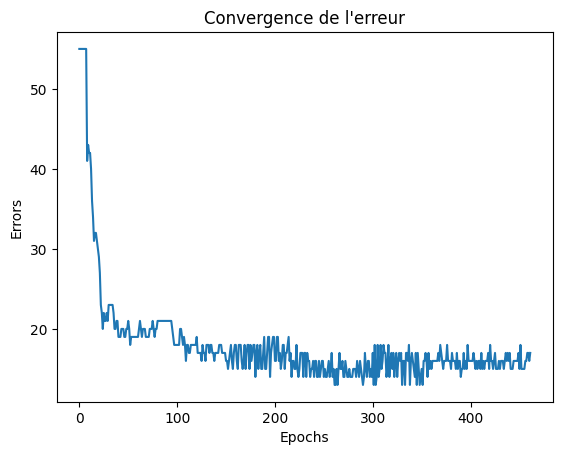

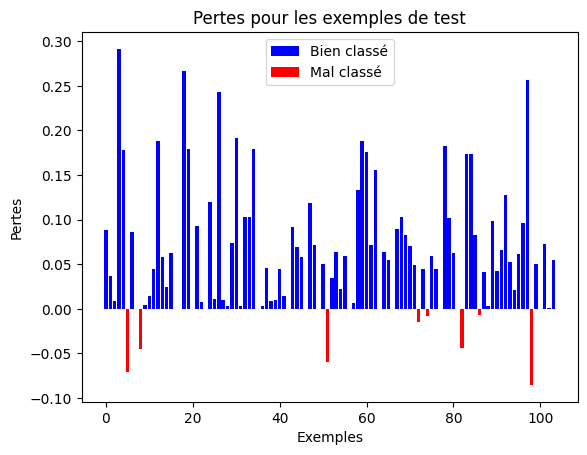

In [104]:
# affichage de stabilité
stability = []
for inputs, label in zip(train_features, train_labels):
    inputs_with_bias = np.insert(inputs, 0, 1)
    stability.append((np.dot(inputs_with_bias, weights4) * label) / np.linalg.norm(weights4[1:]))

# affichage des résultats
print(f"Accuracy sur le jeu d'entraînement : {training_accuracy4}")
print(f"Accuracy sur le jeu de test : {testing_accuracy4}")

print(f"Erreur d'apprentissage (Ea) : {Ea4}")
print(f"Erreur de généralisation (Eg) : {Eg4}")
print(f"Stabilité : {np.mean(stability)}")
print(f"Poids : {weights4}")

# Affichage de graphique de convergence de l'erreur
plt.plot(range(len(errors_method2)), errors_method2)
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Convergence de l\'erreur')
plt.show()



# Affichage du graphique
plt.bar(range(len(stability)), [val if val > 0 else 0 for val in stability], 
        color='blue', label='Bien classé')

# Barres pour les exemples classés comme roches
plt.bar(range(len(stability)), [val if val < 0 else 0 for val in stability], 
        color='red', label='Mal classé')

# Ajout des étiquettes
plt.xlabel('Exemples')
plt.ylabel('Pertes')
plt.title('Pertes pour les exemples de test')
plt.legend()
plt.show()